<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install -Uq scikit-learn

In [2]:
# импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    make_scorer, 
    mean_squared_error, 
    root_mean_squared_error
)
from sklearn.pipeline import Pipeline


RANDOM_STATE = 42

In [3]:
# считываем файл taxi, устанавливаем индекс таблицы и выводим первые пять строк на экран
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# выведем информацию о taxi
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# ресемплирование данных по одному часу
taxi = taxi.resample('1H').sum()
taxi

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Датасет включает данные с 1 марта 2018 года по 31 августа 2018 года. Мы имеем 4416 строк, в каждой строке указано количество заказов такси за данный час. Всего весной и летом в сумме 92 дня, то есть 4416 часов, значит пропусков в данных нет.

## Анализ

<Figure size 1080x720 with 0 Axes>

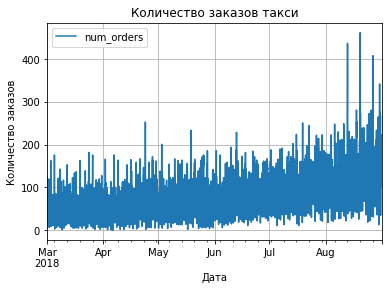

In [6]:
plt.figure(figsize=(15, 10))
taxi.plot()
plt.title('Количество заказов такси')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

График указывает на увеличение заказов с течением времени. В течение полугода наблюдается постепенный рост числа заказов, с заметными пиками, которые могут быть связаны с конкретными событиями или временными периодами.

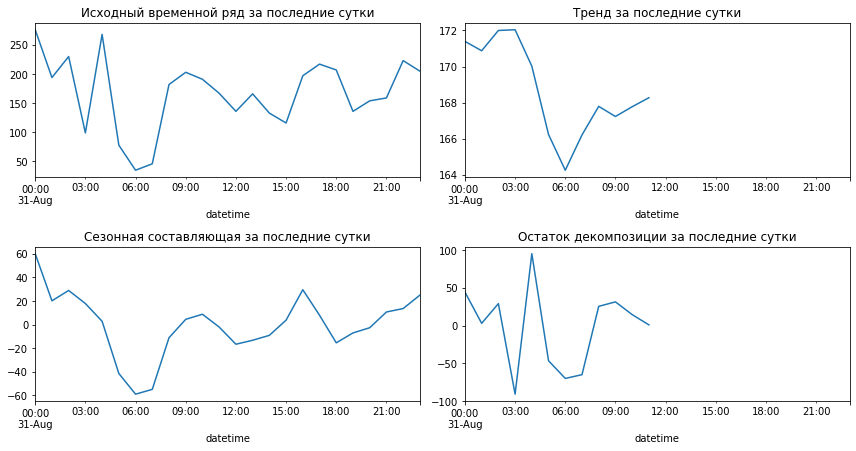

In [7]:
# декомпозиция
# период 24 часа
decomposed = seasonal_decompose(taxi, model='additive', period=24) 

# графики декомпозиции за последние сутки
plt.figure(figsize=(12, 12))

plt.subplot(4, 2, 1)
decomposed.observed['2018-08-31':'2018-08-31'].plot()
plt.title('Исходный временной ряд за последние сутки')

plt.subplot(4, 2, 2)
decomposed.trend['2018-08-31':'2018-08-31'].plot()
plt.title('Тренд за последние сутки')

plt.subplot(4, 2, 3)
decomposed.seasonal['2018-08-31':'2018-08-31'].plot()
plt.title('Сезонная составляющая за последние сутки')

plt.subplot(4, 2, 4)
decomposed.resid['2018-08-31':'2018-08-31'].plot()
plt.title('Остаток декомпозиции за последние сутки')

plt.tight_layout()
plt.show()

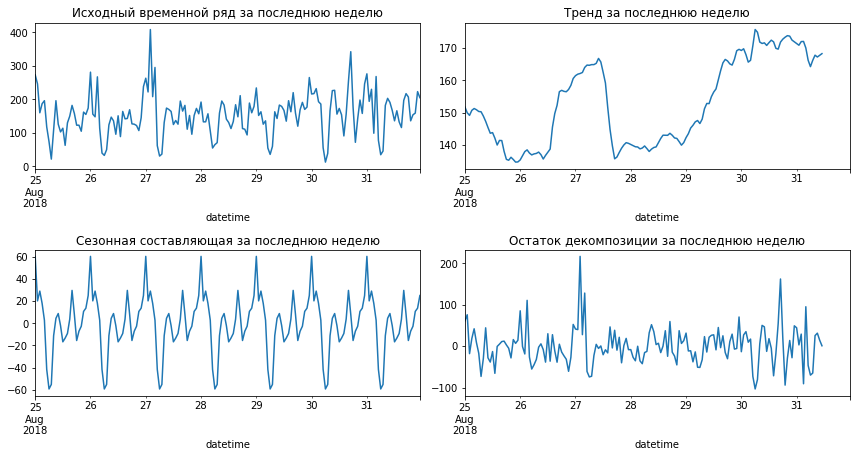

In [8]:
# графики декомпозиции за последнюю неделю
plt.figure(figsize=(12, 12))

plt.subplot(4, 2, 1)
decomposed.observed['2018-08-25':'2018-08-31'].plot()
plt.title('Исходный временной ряд за последнюю неделю')

plt.subplot(4, 2, 2)
decomposed.trend['2018-08-25':'2018-08-31'].plot()
plt.title('Тренд за последнюю неделю')

plt.subplot(4, 2, 3)
decomposed.seasonal['2018-08-25':'2018-08-31'].plot()
plt.title('Сезонная составляющая за последнюю неделю')

plt.subplot(4, 2, 4)
decomposed.resid['2018-08-25':'2018-08-31'].plot()
plt.title('Остаток декомпозиции за последнюю неделю')

plt.tight_layout()
plt.show()

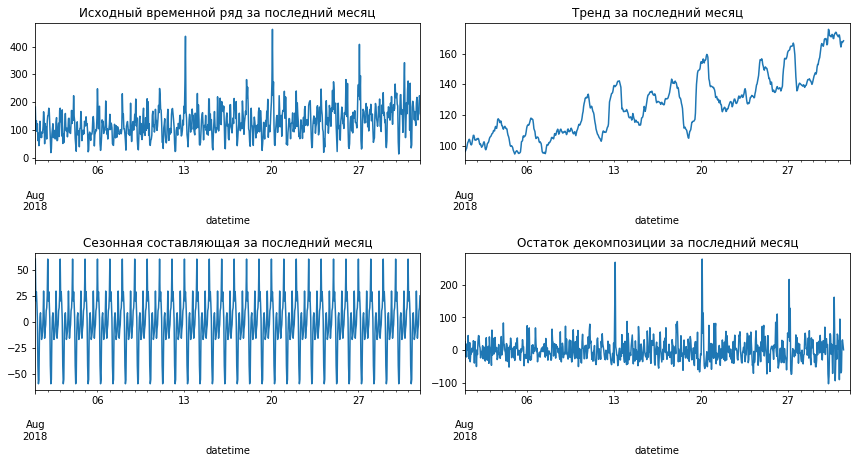

In [9]:
# графики декомпозиции за последний месяц
plt.figure(figsize=(12, 12))

plt.subplot(4, 2, 1)
decomposed.observed['2018-08-01':'2018-08-31'].plot()
plt.title('Исходный временной ряд за последний месяц')

plt.subplot(4, 2, 2)
decomposed.trend['2018-08-01':'2018-08-31'].plot()
plt.title('Тренд за последний месяц')

plt.subplot(4, 2, 3)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot()
plt.title('Сезонная составляющая за последний месяц')

plt.subplot(4, 2, 4)
decomposed.resid['2018-08-01':'2018-08-31'].plot()
plt.title('Остаток декомпозиции за последний месяц')

plt.tight_layout()
plt.show()

Декомпозиция демонстрирует нам, что тренд стабильно увеличивается, а сезонные колебания остаются постоянными по амплитуде на протяжении всего наблюдаемого периода. Остаток имеет высокую частоту колебаний, но их амплитуда остаётся относительно стабильной. Это говорит нам о наличии сильных сезонных паттернов в данных.

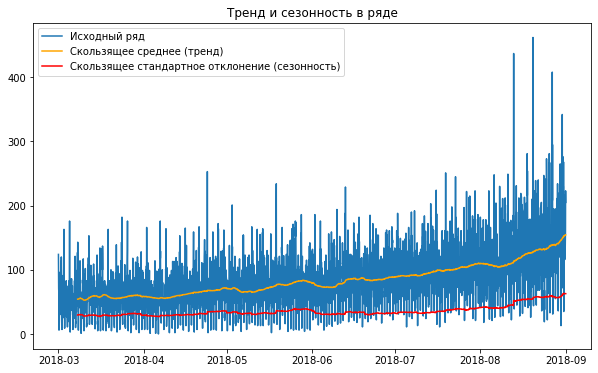

In [10]:
# скользящее среднее и стандартное отклонение
window_size = 24 * 7  # неделя

taxi['rolling_mean'] = taxi['num_orders'].rolling(window=window_size).mean()
taxi['rolling_std'] = taxi['num_orders'].rolling(window=window_size).std()

plt.figure(figsize=(10, 6))

plt.plot(taxi['num_orders'], label='Исходный ряд')
plt.plot(taxi['rolling_mean'], label='Скользящее среднее (тренд)', color='orange')
plt.plot(taxi['rolling_std'], label='Скользящее стандартное отклонение (сезонность)', color='red')

plt.title('Тренд и сезонность в ряде')
plt.legend()
plt.show()

Как мы указывали выше, исходный ряд имеет выраженную восходящую тенденцию (тренд), что указывает на рост числа заказов со временем. Также заметна сезонность: стандартное отклонение варьируется по циклам, что подтверждает наличие временных паттернов, связанных с различными днями недели, временем суток и, возможно, праздниками.

## Обучение

Создадим признаки для горизонта прогнозирования в один шаг.
Напишем функцию для создания признаков. 

In [11]:
taxi = taxi.drop('rolling_std', axis=1)

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    # календарные признаки
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # «Отстающие значения»
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # скользящее среднее   
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

make_features(taxi, 24, 6)

taxi = taxi.dropna()
print(taxi.head(25))

                     num_orders  rolling_mean  day  dayofweek  hour  lag_1  \
datetime                                                                     
2018-03-02 00:00:00          90     69.333333    2          4     0   58.0   
2018-03-02 01:00:00         120     72.166667    2          4     1   90.0   
2018-03-02 02:00:00          75     84.666667    2          4     2  120.0   
2018-03-02 03:00:00          64     87.000000    2          4     3   75.0   
2018-03-02 04:00:00          20     86.666667    2          4     4   64.0   
2018-03-02 05:00:00          11     71.166667    2          4     5   20.0   
2018-03-02 06:00:00          11     63.333333    2          4     6   11.0   
2018-03-02 07:00:00           7     50.166667    2          4     7   11.0   
2018-03-02 08:00:00          46     31.333333    2          4     8    7.0   
2018-03-02 09:00:00          45     26.500000    2          4     9   46.0   
2018-03-02 10:00:00          54     23.333333    2          4   

In [14]:
# создаем целевую переменную и признаки
X = taxi.drop(columns=['num_orders'])
y = taxi['num_orders']

# делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (3952, 28)
Размер тестовой выборки: (440, 28)


In [15]:
# определяем метрику RMSE
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [16]:
# категориальные и числовые признаки
cat_columns = ['day', 'dayofweek', 'hour']
num_columns = ['rolling_mean', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
                    'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
                    'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16',
                    'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22',
                    'lag_23', 'lag_24']
taxi[cat_columns] = taxi[cat_columns].astype('category')

# трансформер для предобработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),  
        ('cat', OneHotEncoder(drop='first', handle_unknown='error'), cat_columns)],
    remainder='passthrough'
)


In [17]:
# cоздание пайплайна с препроцессором и моделью LinearRegression
model_lr  = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# oпределение параметров для оптимизации LinearRegression
param_grid_lr = {
    'regressor__fit_intercept': [True, False]
}
# Создание объекта GridSearchCV для LinearRegression
grid_search_lr = GridSearchCV(
    model_lr,
    param_grid_lr,
    scoring=rmse_scorer,
    n_jobs=-1,
    cv=5
)

grid_search_lr.fit(X_train, y_train)

# вывод лучших параметров для LinearRegression
print("Лучшие параметры для LinearRegression: ", grid_search_lr.best_params_)

# вывод лучшей метрики на кросс-валидации для LinearRegression
print("Лучшая метрика на кросс-валидации для LinearRegression: ", -grid_search_lr.best_score_)

Лучшие параметры для LinearRegression:  {'regressor__fit_intercept': True}
Лучшая метрика на кросс-валидации для LinearRegression:  24.165726676857396


In [18]:
# cоздание пайплайна с препроцессором и моделью DecisionTreeRegressor
model_tree  = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# oпределение параметров для оптимизации DecisionTreeRegressor
param_grid_tree = {
    'model__max_depth': range(2,10),
    'model__max_features': range(2,10)
}
# Создание объекта GridSearchCV для DecisionTreeRegressor
grid_search_tree = GridSearchCV(
    model_tree,
    param_grid_tree,
    scoring=rmse_scorer,
    n_jobs=-1,
    cv=5
)

grid_search_tree.fit(X_train, y_train)

# вывод лучших параметров для DecisionTreeRegressor
print("Лучшие параметры для DecisionTreeRegressor: ", grid_search_tree.best_params_)

# вывод лучшей метрики на кросс-валидации для DecisionTreeRegressor
print("Лучшая метрика на кросс-валидации для DecisionTreeRegressor: ", -grid_search_tree.best_score_)

Лучшие параметры для DecisionTreeRegressor:  {'model__max_depth': 8, 'model__max_features': 9}
Лучшая метрика на кросс-валидации для DecisionTreeRegressor:  30.219530849533527


Для исследования мы выбрали две модели: линейная регрессия (LinearRegression) и регрессия на деревьях решений (DecisionTreeRegressor). Для каждой модели был настроен поиск оптимальных гиперпараметров с использованием GridSearchCV и кросс-валидации на 5 фолдах. Для оценки качества использовалась метрика RMSE.

Лучшие параметры для LinearRegression: {'fit_intercept': True}, RMSE: 24.166.

Лучшие параметры для DecisionTreeRegressor: {'model__max_depth': 8, 'model__max_features': 9}, RMSE: 30.212.

Так как метрика RMSE у линейной регресии меньше, мы выбираем эту модель лучшей.

## Тестирование

In [19]:
# оценка производительности на тестовой выборке
best_model = grid_search_lr.best_estimator_
y_pred = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE для лучшей модели: {rmse}')

RMSE для лучшей модели: 41.8986533591686


Линейная регрессия с параметром fit_intercept=True на тестовой выборке показала RMSE: 41.9. Это значение показывает среднюю ошибку модели в предсказании количества заказов такси на один час.

Значение RMSE на тестовой выборке в 41.39 указывает на приемлемую точность модели, для дальнейшего улучшения результатов можно попробовать увеличить количество признаков, добавить более сложные модели (например, градиентный бустинг) или увеличить количество данных для обучения.

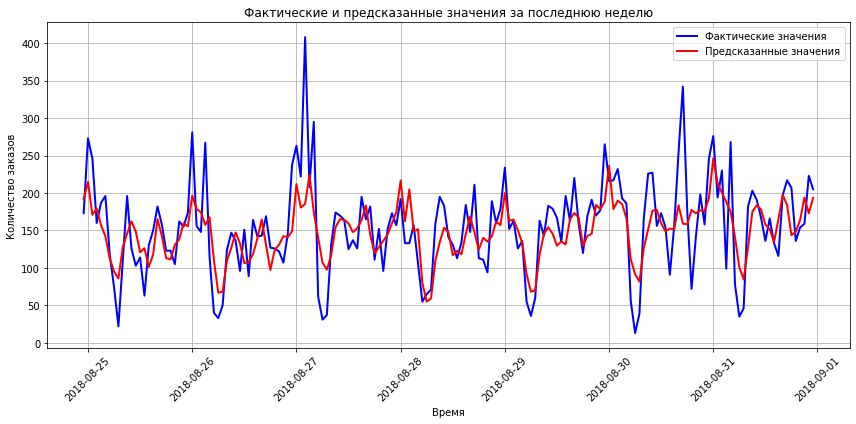

In [20]:
# отбор данных за последнюю неделю
last_week = y_test.index[-1] - pd.Timedelta('7 days')
y_test_last_week = y_test[y_test.index >= last_week]
y_pred_last_week = y_pred[y_test.index >= last_week]

# построение графика фактических и предсказанных значений
plt.figure(figsize=(12, 6))
plt.plot(y_test_last_week.index, y_test_last_week, label='Фактические значения', color='blue', linewidth=2)
plt.plot(y_test_last_week.index, y_pred_last_week, label='Предсказанные значения', color='red', linewidth=2)
plt.title('Фактические и предсказанные значения за последнюю неделю')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

Мы визуализировали реальные и предсказанные данные за последнюю неделю. 
В целом, можно заметить, что модель достаточно точно улавливает общие тренды, но на некоторых пиках и провалах предсказания могут отличаться от реальных значений.

## Вывод

В рамках данного проекта была решена задача прогнозирования количества заказов такси на следующий час для компании «Чётенькое такси».
 
В работе было выполнено ресемплирование данных по одному часу, так же были созданы новые признаки для улучшения предсказательной способности.

Для исследования мы выбрали две модели: линейная регрессия (LinearRegression) и регрессия на деревьях решений (DecisionTreeRegressor). Для каждой модели был настроен поиск оптимальных гиперпараметров с использованием GridSearchCV и кросс-валидации на 5 фолдах. Для оценки качества использовалась метрика RMSE.
Лучшей моделью была выбрана линейная регрессия с гиперпараметром {'fit_intercept': True} и метрикой RMSE на кросс-валидации равной 24.17.

На тестовой выборке, что составили 10%  всех данных, модель показала значение RMSE 41.9, что свидетельствует о хорошей способности модели прогнозировать количество заказов такси и соответствует поставленной цели проекта (RMSE не больше 48).
Визуализация предсказаний за последнюю неделю продемонстрировала, что модель улавливает основные тенденции изменения спроса, хотя на некоторых пиках точность предсказаний может снижаться. Для дальнейшего улучшения результатов можно попробовать увеличить количество признаков, добавить более сложные модели (например, градиентный бустинг) или увеличить количество данных для обучения.